# Passive cable with synapses

As we saw in [this notebook](../03_Hodgkin-Huxley/Cable_equation.ipynb), in its simplest formulation, the cable equation is a PDE that describes how voltage spreads through an unbranched piece of dendrite. It is given by

$\tau_m \frac{\partial}{\partial t}V_m(x,t) = \lambda^2 \frac{\partial^2}{\partial x^2}V_m(x,t) - V_m(x,t)$,

where $\tau_m=r_m c_m$ is the membrane time constant and $\lambda=\sqrt{\frac{d r_m}{4r_a}}$ is the __length constant__ of the neuron.

Here, we show how this theoretical framework can be used to simulate the activation of synaptic inputs in different locations of the cable and how post-synaptic potentials (PSPs) travel down the dendrite.

In [1]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

As before, the function below implements a discretized version of the cable equation. The difference with the previous implementation is that now we have one synapse per compartment, each of which adds a variable `gsyn` representing the conductance of the synapse. `Esyn` is the reversal potential of the synapse. 

In [2]:
def cable(t,Vm,Cm,Rm,Ra,Em,gsyn,Esyn):
    # VM: [mV]
    # Em: [mV]
    # Cm: [pF]
    # Rm: [MΩ]
    # Ra: [MΩ]
    # gsyn: [nS]
    # Esyn: [mV]
    Vm_   = Vm*1e-3    # [V]
    Em_   = Em*1e-3    # [V]
    Cm_   = Cm*1e-12   # [F]
    Rm_   = Rm*1e6     # [Ω]
    Ra_   = Ra*1e6     # [Ω]
    gsyn_ = gsyn*1e-9  # [S]
    Esyn_ = Esyn*1e-3  # [V]
    ncomp = Vm.size
    dvdt = np.zeros(ncomp)
    for i in range(1,ncomp-1):
        dvdt[i] = (-(Vm_[i]-Em_)/Rm_[i] + (Vm_[i-1]-2*Vm_[i]+Vm_[i+1])/Ra_[i] - gsyn_[i]*(Vm_[i]-Esyn_)) / Cm_[i]
    i = 0
    dvdt[i] = (-(Vm_[i]-Em_)/Rm_[i] - (Vm_[i]-Vm_[i+1])/Ra_[i] - gsyn_[i]*(Vm_[i]-Esyn_)) / Cm_[i]
    i = ncomp-1
    dvdt[i] = (-(Vm_[i]-Em_)/Rm_[i] + (Vm_[i-1]-Vm_[i])/Ra_[i] - gsyn_[i]*(Vm_[i]-Esyn_)) / Cm_[i]
    return dvdt*1e3

Here we define the geometric parameters of the cable:

In [3]:
cm   = 1    # [μF/cm2]
Em   = -70  # [mV]
rm   = 1e4  # [Ω cm2]
ra   = 100  # [Ω cm]
diam = 4    # [μm]
τm   = rm*cm*1e-6 # [s]
λ = np.sqrt(diam*1e-6/(4*ra*1e-2/(rm*1e-4))) * 1e2 # [cm]
n_λ = 2
L = n_λ*λ
print(f'  membrane capacitance  cm = {cm:5g} μF/cm2')
print(f'  membrane resistivity  rm = {rm:5g} Ω cm2')
print(f'membrane time constant  τm = {τm*1e3:5g} ms')
print(f'     axial resistivity  ra = {ra:5g} Ω cm')
print(f'       length constant   λ = {λ*1e4:5.0f} μm')
print(f'          cable length   L = {L:9.3f} cm')

  membrane capacitance  cm =     1 μF/cm2
  membrane resistivity  rm = 10000 Ω cm2
membrane time constant  τm =    10 ms
     axial resistivity  ra =   100 Ω cm
       length constant   λ =  1000 μm
          cable length   L =     0.200 cm


Here we discretize the cable, by using `ncomp_λ` isopotential compartments for each length constant of the cable. We also compute the total capacitance, membrane resistance and axial resistance for each compartment.

In [4]:
ncomp_λ = 10
ncomp = ncomp_λ * n_λ + 1
length = L/ncomp + np.zeros(ncomp)
surface_area = np.pi * (diam*1e-4) * length # [cm2]
section_area = np.pi * (diam*1e-4/2)**2     # [cm2]
Cm = cm * surface_area * 1e6           # [pF]
Rm = rm / surface_area * 1e-6          # [MΩ]
Ra = ra * length / section_area * 1e-6 # [Ω]
print('Each compartment has:')
print(f'membrane capacitance  Cm = {Cm[0]:.1f} pF')
print(f' membrane resistance  Rm = {Rm[0]:.1f} MΩ')
print(f'    axial resistance  Ra = {Ra[0]:.1f} MΩ')

Each compartment has:
membrane capacitance  Cm = 12.0 pF
 membrane resistance  Rm = 835.6 MΩ
    axial resistance  Ra = 7.6 MΩ


Here we consider conductance-based synapses, which follow the same formalism introduced by Hodgkin and Huxley for ionic currents. <br/>
The synaptic current in each compartment is defined by the following equation:

$I_{syn}(t) = g_{syn}(t) (E_{syn} - V_m(t))$,

where $g_{syn}(t)$ is the time course of the synaptic conductance and $E_{syn}$ is the reversal potential. Typically, $E_{syn}=0\,\mathrm{mV}$ for excitatory synapses and $E_{syn}=-70\,\mathrm{mV}$ for inhibitory ones.

Here, we will use a simple first order equation to describe the dynamics of the synaptic conductance:

$g_{syn}' = -\frac{g_{syn}}{\tau_{syn}}$,

which represents an exponentially-decaying synaptic conductance with time constant equal to $\tau_{syn}$. Typically, $\tau_{syn}=5\,\mathrm{ms}$ for AMPA-mediated synapses and $\tau_{syn}=10\,\mathrm{ms}$ for GABA-mediated ones. NMDA conductances are usually characterized by longer (or multiple) time constants. The state variables $g_{syn}$ are instantaneously incremented by a fixed value any time a presynaptic spike occurs.

Let's define the synaptic parameters:
1. reversal potential
1. time constant
1. synaptic weights, i.e., the amount by which each synaptic conductance is increased every time there is a spike
1. times of presynaptic spikes: here we activate each synapse sequentially.

In [5]:
# duration of the simulation
tend = (ncomp+1) * 10 * τm + τm
# an excitatory synapse
Esyn   = 0     # [mV]
tausyn = 5e-3  # [s]
tpre = np.r_[τm : tend : (10*τm)] # [s]
weights = diam + np.zeros(ncomp)     # [nS]

Here we set the initial conditions for both the membrane potential and synaptic conductances and initialize the simulation:

In [6]:
dt = 0.01e-3
t = np.r_[0 : tend : dt]
nsteps = t.size
X = np.zeros((ncomp*2, nsteps))
Vm = X[:ncomp,:]
gsyn = X[ncomp:,:]
Vm[:,0] = Em

We perform the integration using the Euler method, which allows us to more easily deal with the presynaptic times. Note however that we need to use a very short time step in order for the simulation to be stable.

In [7]:
for i in range(nsteps-1):
    for j in range(ncomp):
        if t[i] >= tpre[j] and t[i-1] < tpre[j]:
            gsyn[j,i] += weights[j]
    Vm[:,i+1] = Vm[:,i] + dt * cable(t[i], Vm[:,i], Cm, Rm, Ra, Em, gsyn[:,i], Esyn)
    gsyn[:,i+1] = gsyn[:,i] - dt*gsyn[:,i]/tausyn

Let's plot the results:

In [8]:
# the peak of each PSP
ΔV = np.max(Vm, axis=1) - Em
# the indices of the peaks in the membrane voltage at the left boundary of the cable
pks,_ = find_peaks(Vm[0,:], height=-69)
# the peak of the PSPs as "seen" from the left boundary
ΔV_soma = Vm[0,pks] - Em

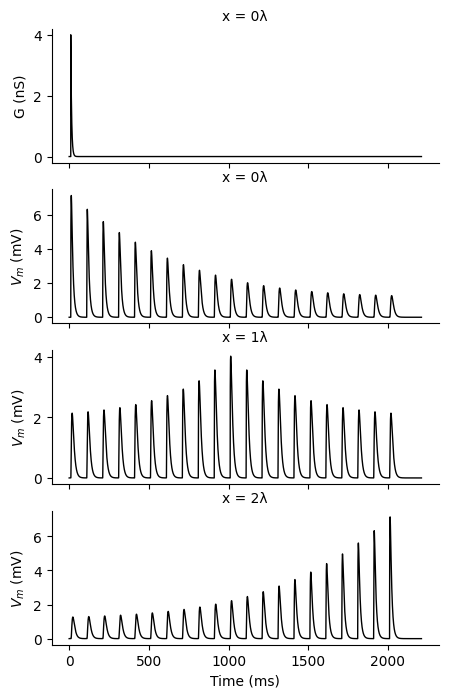

In [9]:
fig,ax = plt.subplots(4, 1, figsize=(5,8), sharex=True)
i = 0
ax[0].plot(t*1e3, gsyn[i,:], 'k', lw=1)
ax[1].plot(t*1e3, Vm[i,:]-Em, 'k', lw=1)
ax[2].plot(t*1e3, Vm[ncomp//2,:]-Em, 'k', lw=1)
ax[3].plot(t*1e3, Vm[-1,:]-Em, 'k', lw=1)
ax[0].set_title('x = 0λ', fontsize=10)
ax[1].set_title('x = 0λ', fontsize=10)
ax[2].set_title(f'x = {n_λ/2:g}λ', fontsize=10)
ax[3].set_title(f'x = {n_λ:g}λ', fontsize=10)
ax[-1].set_xlabel('Time (ms)')
ax[0].set_ylabel('G (nS)')
for a in ax[1:]:
    a.set_ylabel(r'$V_m$ (mV)')
sns.despine()

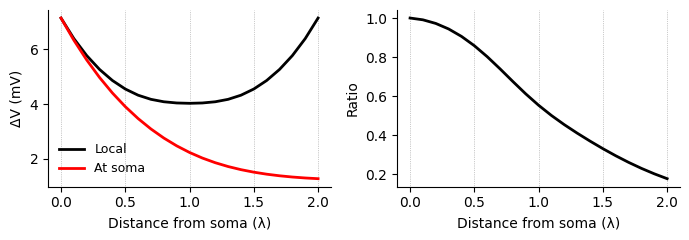

In [10]:
x = np.linspace(0, n_λ, ncomp)
fig,ax = plt.subplots(1, 2, figsize=(7,2.5), sharex=True)
ax[0].plot(x, ΔV, 'k', lw=2, label='Local')
ax[0].plot(x, ΔV_soma, 'r', lw=2, label='At soma')
ax[1].plot(x, ΔV_soma/ΔV, 'k', lw=2)
for a in ax:
    a.set_xlabel('Distance from soma (λ)')
    a.grid(which='major', axis='x', ls=':', lw=0.5, color=[.6,.6,.6])
ax[0].legend(loc='lower left', frameon=False, fontsize=9)
ax[0].set_ylabel('ΔV (mV)')
ax[1].set_ylabel('Ratio')
sns.despine()
fig.tight_layout()